In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/colab/bonus1

/content/drive/MyDrive/colab/bonus1


In [ ]:
!pip install transformers
!pip install numpy==1.17.3
!pip install -q -U watermark
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
from time import time  # To time our operations

from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import json
from typing import Dict
from pathlib import Path

+ 基本參數設定

In [8]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# 設定畫圖背景樣式、調色盤樣式、字型大小
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
# 設定調色盤顏色
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
# 設定畫布大小
rcParams['figure.figsize'] = 12, 8

# 設定隨機變數
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
# 設定使用 GPU（第0張）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## 2. 資料前處理

In [9]:
class GPReviewDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.reviews)
  
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          review,
          truncation=True,
          add_special_tokens=True,
          max_length=self.max_len, #句子的最大長度
          padding='max_length',
          return_token_type_ids=False,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(), # encode 完之後的 token id
          'attention_mask': encoding['attention_mask'].flatten(), # encode 完之後的 attention mask
          'targets': torch.tensor(target, dtype=torch.long)
        }

class GPReviewDataset_test(Dataset):

    def __init__(self, reviews, tokenizer, max_len):
        self.reviews = reviews
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.reviews)
  
    def __getitem__(self, item):
        review = str(self.reviews[item])
        encoding = self.tokenizer.encode_plus(
          review,
          truncation=True,
          add_special_tokens=True,
          max_length=self.max_len, #句子的最大長度
          padding='max_length',
          return_token_type_ids=False,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(), # encode 完之後的 token id
          'attention_mask': encoding['attention_mask'].flatten(), # encode 完之後的 attention mask
        }

In [10]:
def create_data_loader(df, text, target, tokenizer, max_len, batch_size):
    # ds：GPReviewDataset 處理後的回傳結果
    ds = GPReviewDataset(
        reviews=df[text].to_numpy(), # 要預測的句子
        targets=df[target].to_numpy(), # 要預測的目標
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

def create_data_loader_test(df,text, tokenizer, max_len, batch_size):
    ds = GPReviewDataset_test(
        reviews=df[text].to_numpy(), # 要預測的句子
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

def trans_intent(df,col,trans_dict):
  if col in df.columns:
    df[col] = df[col].replace(trans_dict, regex=True)
  return df

In [11]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        # 定義會用到的方法
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) #bert model
        self.drop = nn.Dropout(p=0.3) # dropout layer
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes) # layer sahpe, 預測幾類
  
    def forward(self, input_ids, attention_mask):
        # 把上面定義的方法串起來
        model_output = self.bert( 
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(model_output.pooler_output)
        
        return self.out(output)

In [12]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0
  
    for d in data_loader:
        # 1.把訓練資料放到 GPU 上
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        # 2.拿出模型預測結果(預測各類別的機率)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        
        # 3 取出預測機率的最大值，當作最終預測類別
        _, preds = torch.max(outputs, dim=1)
        # 比較預測機率和真實標籤的差異算loss
        loss = loss_fn(outputs, targets)
        
        # 計算正確預測的數量，並儲存loss
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # 4. 更新模型參數
        loss.backward()
        # 為了避免梯度爆炸，將梯度限制在１以內
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [13]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            # 1.把訓練資料放到 GPU 上
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # 2.拿出模型預測結果(預測各類別的機率)
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            
            # 3 取出預測機率的最大值，當作最終預測類別
            _, preds = torch.max(outputs, dim=1)
            # 比較預測機率和真實標籤的差異算loss
            loss = loss_fn(outputs, targets)
            # 計算正確預測的數量，並儲存loss
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [14]:
target_col = 'intent'
text_col = 'text'

data_dir = Path('intent')
SPLITS = ["train", "eval","test"]

# 讀取 Intent id對應
intent_idx_path = Path('intent') / "intent2idx.json"
intent2idx: Dict[str, int] = json.loads(intent_idx_path.read_text())

# 讀取訓練資料
data_paths = {split: data_dir / f"{split}.json" for split in SPLITS} # 路徑
data_df = {split: pd.read_json(path) for split, path in data_paths.items()} # 資料本身
data_df = {k: trans_intent(v,target_col,intent2idx) for k, v in data_df.items()} # 轉換 Intent 編號

# x標籤
class_names = list(intent2idx.keys())

### 定義模型參數

In [21]:
# 指定預訓練模型種類
PRE_TRAINED_MODEL_NAME = "bert-base-chinese"
# 定義 tokenizer (處理句子的模式)
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# 訓練流程參數
EPOCHS = 1 # EPOCHS = 10 
BATCH_SIZE = 128
MAX_LEN = 16 # 512

## 轉換資料格式

In [18]:
df_train = data_df['train']
df_val = data_df['train']
df_test = data_df['test']

# 處理 train / validation / test 的 data loader
train_data_loader = create_data_loader(df_train, text_col, target_col , tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, text_col, target_col, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader_test(df_test, text_col, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [19]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Downloading:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

In [20]:
# 確認資料轉換格式
data = next(iter(train_data_loader))
data.keys()

# 確認資料維度
# sahpe = (BATCH_SIZE * MAX_LEN)
print(data['input_ids'].shape)
print(data['attention_mask'].shape)

# sahpe = BATCH_SIZE
print(data['targets'].shape)

torch.Size([128, 16])
torch.Size([128, 16])
torch.Size([128])


## 定義完整模型與訓練、驗證流程

In [ ]:
%%time
t = time()

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    # 1.取得每次迭代模型，訓練資料的準確率和loss
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    # 2.取得每次迭代模型，驗證資料的準確率和loss
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    
    # 3. 儲存每次迭代訓練、驗證集的準確率和loss
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # 以驗證集的準確率為標準，儲存最佳的模型
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc
        
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Epoch 1/1
----------


### 檢視訓練結果

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## 4.1 檢視總體訓練結果

In [ ]:
# 有存模型再跑這段
# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load('model/en/best_model_state.bin'))
# model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 預測驗證集資料


In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

print(f"accuracy of test data: {test_acc.item()}")

accuracy of test data: 0.881979695431472


### 定義取出訓練結果的函數

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
  
    review_texts = [] # 存要預測的評論
    predictions = [] # 存預測結果
    prediction_probs = [] # 存預測機率
    real_values = [] # 存真實標籤

    with torch.no_grad():
        for d in data_loader:
            # 1.把訓練資料放到 GPU 上
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # 2.拿出模型預測結果(預測各類別的機率)
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            
            # 3. 取出預測機率的最大值，當作最終預測類別
            _, preds = torch.max(outputs, dim=1)
            probs = F.softmax(outputs, dim=1)
            
            # 4. 儲存要預測的評論資料與預測結果
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [ ]:
# 取出測試集的預測結果
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

### 檢視預測結果
首先檢視各個類別的`precision`,`recall`,`f1-score`，看起來中性和負面的評論表現較差

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.90      0.84      0.87       245
     neutral       0.84      0.86      0.85       254
    positive       0.91      0.93      0.92       289

    accuracy                           0.88       788
   macro avg       0.88      0.88      0.88       788
weighted avg       0.88      0.88      0.88       788



查看各個類別的混淆矩陣，發現正面和負面的評論混淆成中性的情況較多，中性的評論也常混淆成這兩者。

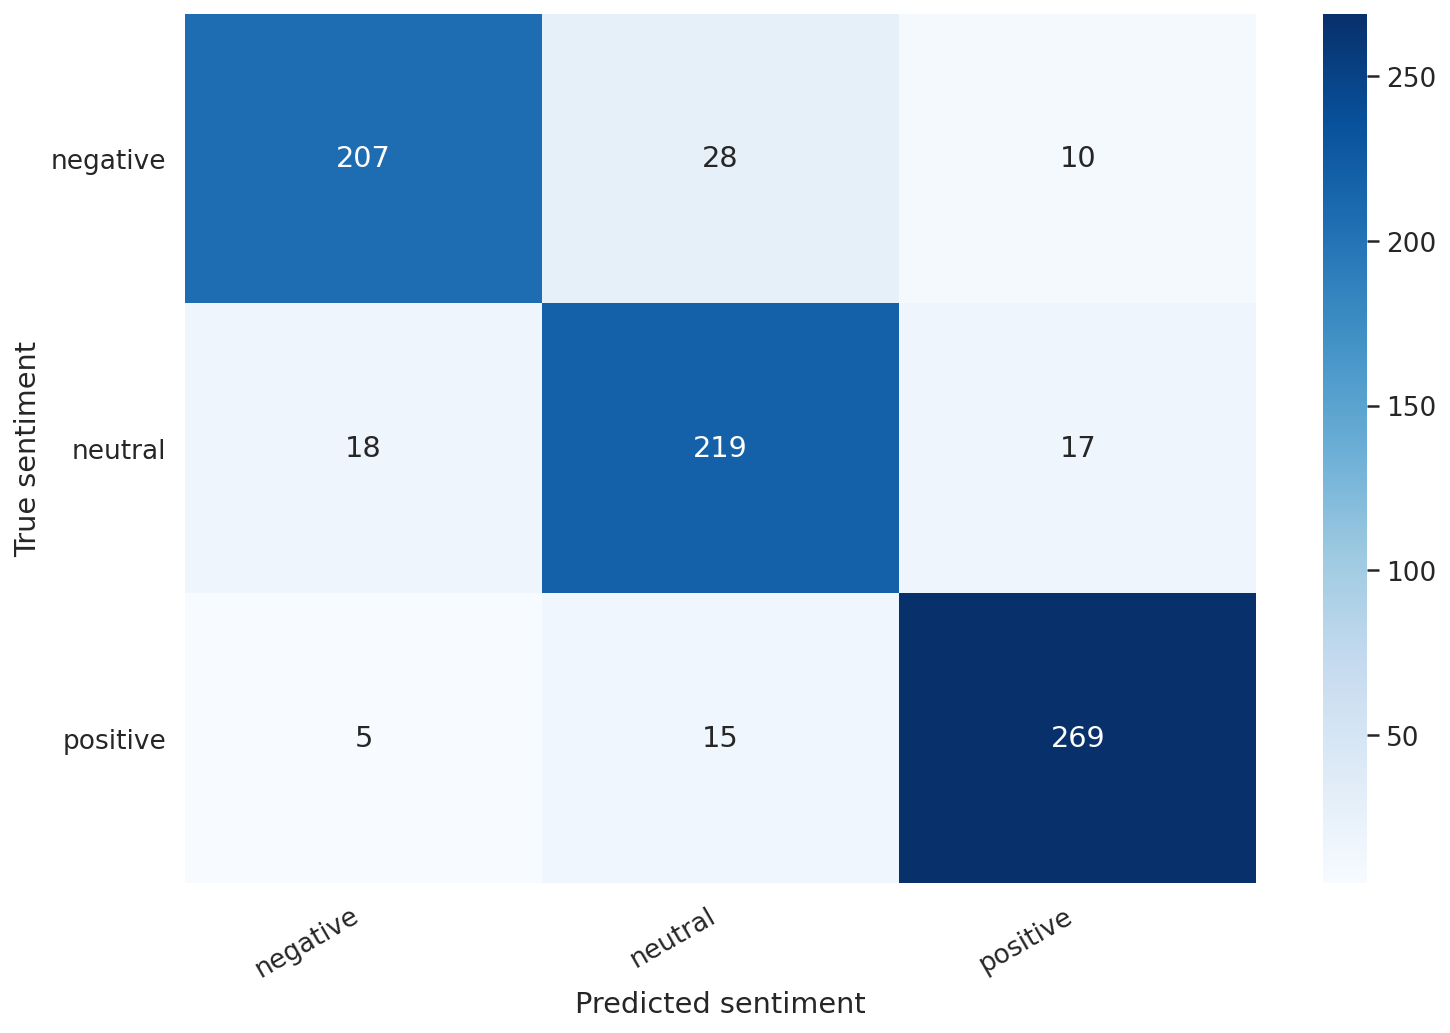

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## 4.2 個別句子的預測分析


In [ ]:
# 拿測試資料集的第三筆資料
idx = 2
review_text = y_review_texts[idx] # 要預測的資料
true_sentiment = y_test[idx] # 真實標籤

# 將預測結果整合成dataframe
pred_df = pd.DataFrame({
  'class_names': class_names, # 三種情緒標籤
  'values': y_pred_probs[idx] # 單筆預測機率
})
pred_df

,class_names,values
0,negative,0.000251
1,neutral,0.999507
2,positive,0.000241


In [ ]:
print("original text: ")
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

original text: 
I used to use Habitica, and I must say this is a great step up. I'd
like to see more social features, such as sharing tasks - only one
person has to perform said task for it to be checked off, but only
giving that person the experience and gold. Otherwise, the price for
subscription is too steep, thus resulting in a sub-perfect score. I
could easily justify $0.99/month or eternal subscription for $15. If
that price could be met, as well as fine tuning, this would be easily
worth 5 stars.

True sentiment: neutral


### 機率長條圖
將單筆資料預測各個類別的機率化成長條圖，看起來對這筆資料模型預測的滿準的

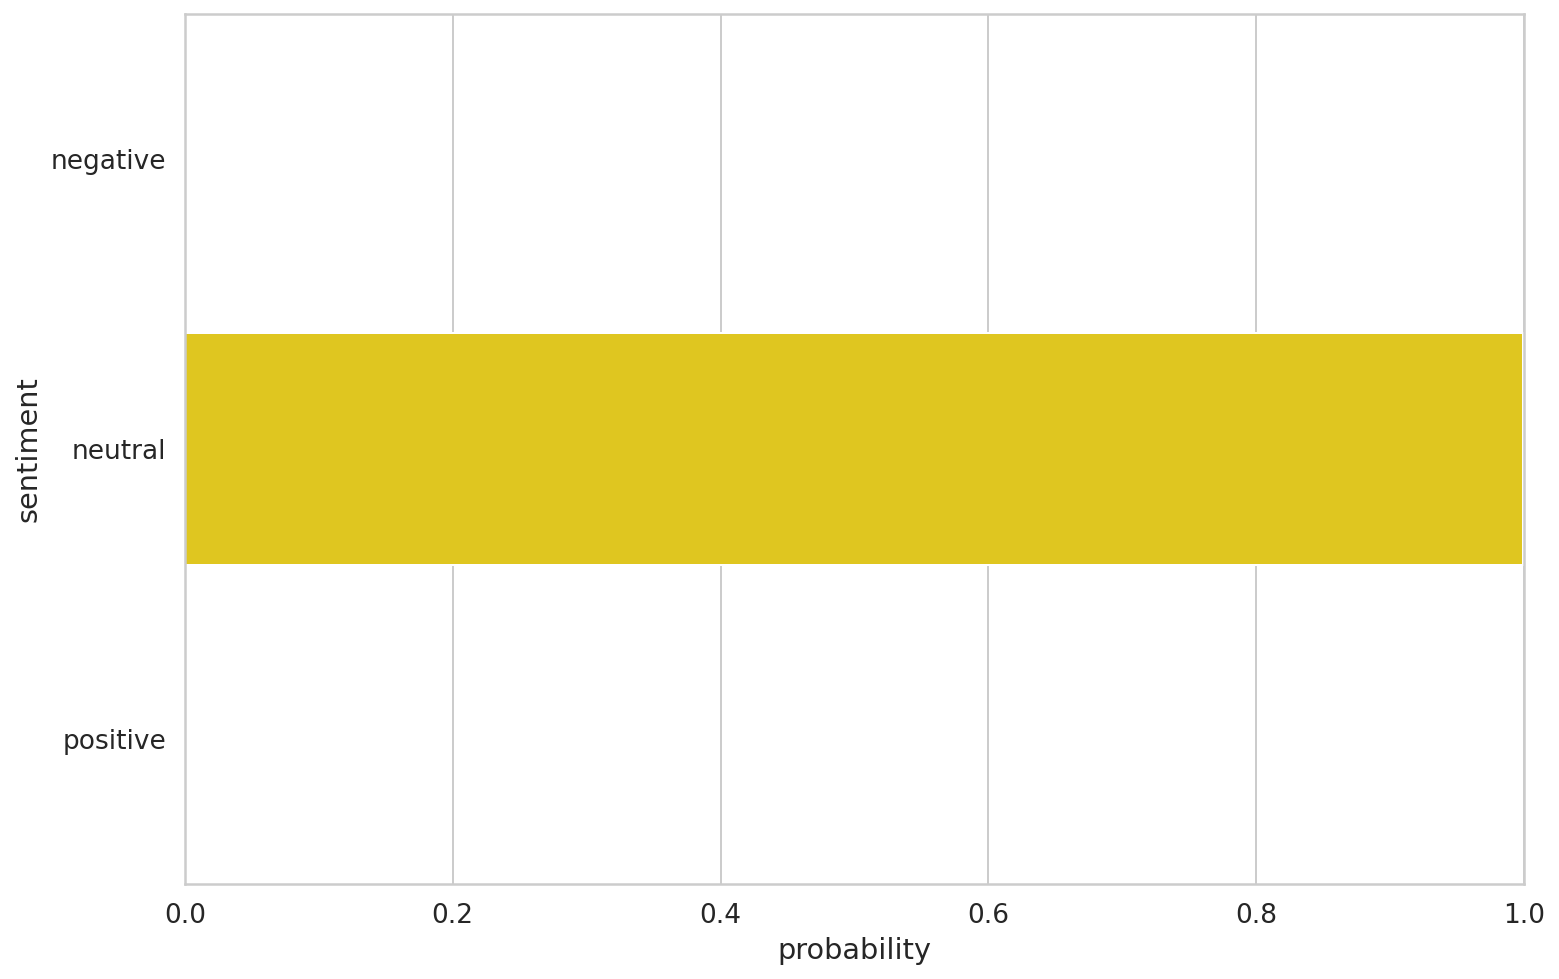

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### 預測自定的新句子
除了data_loder載入的資料集，也可以自己輸入新句看預測結果。

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/ann2/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive


## 結論
1. 如何建構一個完整的BERT模型
    + 將資料分為訓練、驗證與測試資料集：訓練集用來更新模型參數、驗證集可檢驗迭代過程中模型的訓練效果，最後將訓練模型套用在測試集上預測結果。
    + 先將資料轉換為 token_ID 與 attention_mask 再送入模型作訓練
    + 可從 Transformer library 下載預訓練好的模型，再自行定義下游任務作預測
    + 經由迭代的過程更新模型參數，並儲存效果最佳的模型
2. 什麼樣的類別預測的效果較好？
    + 正面類別的資料預測效果最好，中性資料則容易混淆成其他兩類情緒

## 相關連結
+ 教學影片
    + Text Preprocessing 資料前處理
    + https://www.youtube.com/watch?v=Osj0Z6rwJB4
    + Text Classification 分類任務
    + https://www.youtube.com/watch?v=8N-nM3QW7O0        
+ 套件
    + transformers 官網
    + https://huggingface.co/docs/transformers/index
+ 參考教材：
    + Sentiment Analysis with BERT
    + https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/?fbclid=IwAR2hFMfTqG7ielGSfrtzEbUIH7EPXNOLG3dIQidMwiOh-wISSWL-sYf8Yhg